<div style="font-variant: small-caps; 
      font-weight: normal; 
      font-size: 35px; 
      text-align: center; 
      padding: 15px; 
      margin: 10px;">
      Dataset processing
  </div> 
  
<div style="
      font-weight: normal; 
      font-size: 25px; 
      text-align: center; 
      padding: 15px; 
      margin: 10px;">
      CHIA
  </div>


  <div style=" float:left; 
      font-size: 12px; 
      line-height: 12px; 
  padding: 10px 15px 8px;">
  Jean-baptiste AUJOGUE -  Hybrid Intelligence
  </div> 


<a id="TOC"></a>

#### Table Of Content

1. [CHIA Texts](#texts) <br>
2. [CHIA Entities](#ents) <br>


#### Useful links

- [CHIA a large annotated corpus of clinical trial eligibility criteria](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7452886/pdf/41597_2020_Article_620.pdf) (paper)
- https://github.com/uf-hobi-informatics-lab/ClinicalTransformerNER/blob/master/tutorial/brat2bio.ipynb
- https://github.com/ctgatecci/Clinical-trial-eligibility-criteria-NER/blob/main/NER%20Preprocessing%20and%20Performance%20Analysis.ipynb

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import re
import copy
import json
import zipfile

# data
import pandas as pd

# text
from spacy.lang.en import English

C:\Users\jb\miniconda3\envs\transformers_nlp\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Custom variables

In [3]:
path_to_repo = os.path.dirname(os.getcwd())
path_to_data = os.path.join(path_to_repo, 'datasets', 'chia')
path_to_src  = os.path.join(path_to_repo, 'src')
path_to_src

'C:\\Users\\jb\\Desktop\\NLP\\perso - Transformers for NLP\\src'

In [4]:
base_dataset_name  = 'chia.zip'
final_dataset_name = 'chia-ner'

#### Custom imports

In [5]:
sys.path.insert(0, path_to_src)

In [6]:
from nlptools.dataset.chia.io import load_texts_from_zipfile, load_entities_from_zipfile
from nlptools.dataset.chia.preprocessing import get_ner_entities, convert_to_bio

<a id="texts"></a>

# 1. CHIA Texts

[Table of content](#TOC)

In [7]:
def load_texts_from_zipfile(zip_file):
    archive = zipfile.ZipFile(zip_file, 'r')
    text_files = [f for f in archive.namelist() if f.endswith('.txt')]
    texts = []
    for text_file in text_files:
        with archive.open(text_file, 'r') as f:
            _id = text_file.split('/')[-1][:-4]
            text = f.read().decode('utf-8').replace('⁄', '/')
            texts.append([_id, text])
            
    df_texts = pd.DataFrame(texts, columns = ['Id', 'Text'])
    return df_texts

In [8]:
folder = os.path.join(path_to_data, final_dataset_name)
if not os.path.isdir(folder):
    os.makedirs(folder)

In [9]:
df_texts = load_texts_from_zipfile(os.path.join(path_to_data, base_dataset_name))

In [10]:
df_texts.head()

,Id,Text
0,NCT00050349_exc,Patients with symptomatic CNS metastases or le...
1,NCT00050349_inc,Patients with biopsy-proven metastatic carcino...
2,NCT00061308_exc,Women of child-bearing potential that do not p...
3,NCT00061308_inc,Have had one prior platinum-based chemotherapy...
4,NCT00094861_exc,Metastatic disease (M1)/stage 4 NSCLC \nPleura...


In [11]:
df_texts.to_csv(os.path.join(path_to_data, final_dataset_name, 'chia_texts.tsv'), sep = "\t", index = False)

<a id="ents"></a>

# 2. CHIA Entities

[Table of content](#TOC)

## 2.1 Load entities

[Table of content](#TOC)

In [11]:
def load_entities_from_zipfile(zip_file):
    archive = zipfile.ZipFile(zip_file, 'r')
    ann_files = [f for f in archive.namelist() if f.endswith('.ann')]
    ent_list = []
    for ann_file in ann_files:
        with archive.open(ann_file, 'r') as f:
            lines = [l.decode('utf-8').replace('⁄', '/').strip() for l in f.readlines()]
            ents = [l.split('\t') for l in lines if l.startswith('T')]
            ents = [
                [ann_file.split('/')[-1][:-4], ent[0], ent[2], ent[1]]
                for ent in ents
            ]
            ents = [
                ent[:-1] + [
                    ent[-1].replace(';', ' ').split(' ')[0], 
                    tuple([int(v) for v in ent[-1].replace(';', ' ').split(' ')[1:]]),
                ]
                for ent in ents
            ]
            ents = [
                ent[:-1] + [min(ent[-1]), max(ent[-1]), ent[-1]]
                for ent in ents
            ]
            ent_list += ents
            
    df_ents = pd.DataFrame(ent_list, columns = [
        'Id', 'Entity_id', 'Mention', 'Category', 'Start_char', 'End_char', 'Char_spans',
    ])
    return df_ents

In [12]:
df_ents = load_entities_from_zipfile(os.path.join(path_to_data, base_dataset_name))
df_ents.shape

(44616, 7)

In [13]:
df_ents.head()

,Id,Entity_id,Mention,Category,Start_char,End_char,Char_spans
0,NCT00050349_exc,T1,CNS metastases,Condition,26,40,"(26, 40)"
1,NCT00050349_exc,T2,leptomeningeal involvement,Condition,44,70,"(44, 70)"
2,NCT00050349_exc,T5,treated,Procedure,144,151,"(144, 151)"
3,NCT00050349_exc,T6,been stable for,Qualifier,164,179,"(164, 179)"
4,NCT00050349_exc,T7,at least six months prior to study start,Temporal,180,220,"(180, 220)"


In [14]:
# A sanity check:
check = []
for _id, text in df_texts.values.tolist():
    df_tmp = df_ents[df_ents.Id == _id]
    check_tmp = df_tmp.apply(
        func = lambda r: [_id, r.Mention, text[r.Start_char: r.End_char], r.Char_spans],
        axis = 1,
    ).values.tolist()
    check += check_tmp
    
df_check = pd.DataFrame(check, columns = ['Id', 'Mention', 'Span', 'Char_spans'])

In [15]:
# Mention and Span are the same for *almost* all entities:
print(df_check[df_check.Mention != df_check.Span].shape)
print(df_check[(df_check.Mention != df_check.Span) & (df_check.Char_spans.apply(len) == 2)].shape)

df_check[(df_check.Mention != df_check.Span) & (df_check.Char_spans.apply(len) == 2)]

(1800, 4)
(13, 4)


,Id,Mention,Span,Char_spans
6361,NCT01352598_inc,prostate cancer,prostate cancer\r,"(383, 399)"
10279,NCT01980680_exc,OHSS development,OHSS development\r,"(75, 92)"
17492,NCT02425774_exc,chronic pancreatitis,chronic pancreatitis\r,"(149, 170)"
21757,NCT02590822_inc,Capacity to provide informed consent before an...,Capacity to provide informed consent before an...,"(0, 110)"
23477,NCT02654912_exc,first trimester,first trimester\r,"(398, 414)"
23859,NCT02668978_exc,Brilliant Blue FCF (E133),Brilliant Blue FCF (E133)\r,"(198, 224)"
25371,NCT02744976_exc,target vessel,target vessel\r,"(269, 283)"
37184,NCT03217409_inc,at the randomization visit,at the randomization visit\r,"(239, 266)"
37307,NCT03223909_exc,3 months before the protocol inclusion,3 months before the protocol inclusion\r,"(1428, 1467)"
37342,NCT03223909_inc,Oxford scale,Oxford scale\r,"(206, 219)"


## 2.2 Get flattened non-overlapping entities

[Table of content](#TOC)

In [16]:
categories = [
    # domain
    'Condition',                     # - in C2Q
    'Device',                        # present in OMOP CDM, can be precise ('Pacemaker') or broad ('barrier method of birth control)
    'Drug',                          # - in C2Q
    'Measurement',                   # - in C2Q
    'Person',                        # Demographic (sex, age), but also contains mislabeled Condition ('Premenopausal', drug users'), mislabeled Measurement ('body mass index') and irrelevant terms ('Incarcerated')
    'Procedure',                     # - in C2Q
    # 'Visit',                         # codable ?
    
    # field
    'Value',                         # - in C2Q
    'Temporal',                      # - in C2Q
    'Qualifier',                     # Originaly a Construct entity. Modifier terms similar to Observation
    'Observation',                   # - in C2Q # greatly overlaps Qualifier, and the delta seems useless
    # 'Reference_point',             # reference point in time, absolute ("3 times the agent's half-life") or relative ('initiation of treatment')
    # 'Mood',                        # useless

    # construct
    # 'Negation',                    # negation expressed as a NER + RelEx problem to be complete
    # 'Multiplier',                  # CAUTION here, as it covers Value ('> 500 mg/m^2') and Logical label ('3 or more')
]

In [17]:
df_ents = get_ner_entities(df_texts, df_ents, categories)

In [18]:
df_ents.head()

,Id,Mention,Start_char,End_char,Entity_id,Category
0,NCT00050349_exc,symptomatic,14,25,"(T65,)",Qualifier
1,NCT00050349_exc,CNS metastases,26,40,"(T1,)",Condition
2,NCT00050349_exc,leptomeningeal involvement,44,70,"(T2,)",Condition
3,NCT00050349_exc,brain metastases,92,108,"(T4,)",Condition
4,NCT00050349_exc,treated,144,151,"(T5,)",Procedure


<AxesSubplot: >

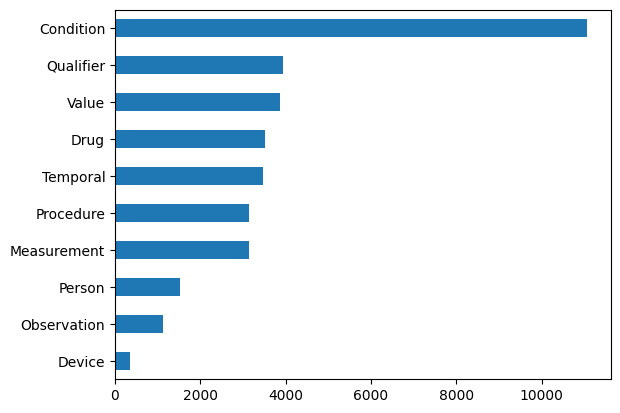

In [22]:
df_ents.Category.value_counts().sort_values().plot(kind = 'barh')

In [20]:
df_ents.to_csv(os.path.join(path_to_data, final_dataset_name, 'chia_ents.tsv'), sep = "\t", index = False)

<a id="bio"></a>

## 2.3 Convert entities to BIO format

[Table of content](#TOC)


In [19]:
df_spans = convert_to_bio(df_texts, df_ents)
df_spans.shape

(76755, 4)

In [20]:
df_spans.head()

,Id,Sequence_id,Mention,Category
0,NCT00050349_exc,NCT00050349_exc_0,Patients with,O
1,NCT00050349_exc,NCT00050349_exc_0,symptomatic,Qualifier
2,NCT00050349_exc,NCT00050349_exc_0,,O
3,NCT00050349_exc,NCT00050349_exc_0,CNS metastases,Condition
4,NCT00050349_exc,NCT00050349_exc_0,or,O


In [23]:
df_spans.to_csv(os.path.join(path_to_data, final_dataset_name, 'chia_spans.tsv'), sep = "\t", index = False)

In [24]:
tokenizer = English()
df_bio = convert_to_bio(df_texts, df_ents, tokenizer = lambda s: [t.text for t in tokenizer(s)])

df_bio.shape

(211076, 4)

In [25]:
df_bio.head(10)

,Id,Sequence_id,Mention,Category
0,NCT00050349_exc,NCT00050349_exc_0,Patients,O
1,NCT00050349_exc,NCT00050349_exc_0,with,O
2,NCT00050349_exc,NCT00050349_exc_0,symptomatic,B-Qualifier
3,NCT00050349_exc,NCT00050349_exc_0,,O
4,NCT00050349_exc,NCT00050349_exc_0,CNS,B-Condition
5,NCT00050349_exc,NCT00050349_exc_0,metastases,I-Condition
6,NCT00050349_exc,NCT00050349_exc_0,,O
7,NCT00050349_exc,NCT00050349_exc_0,or,O
8,NCT00050349_exc,NCT00050349_exc_0,leptomeningeal,B-Condition
9,NCT00050349_exc,NCT00050349_exc_0,involvement,I-Condition


In [26]:
df_bio.to_csv(os.path.join(path_to_data, final_dataset_name, 'chia_bio.tsv'), sep = "\t", index = False)

[Table of content](#TOC)